# Deduplication

In [1]:
import os
os.chdir('..')

In [2]:
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import sqlalchemy
from collections import Counter
import datetime
from __future__ import division
CONFIG_PATH = 'database.yaml'
sns.set(color_codes=True)
%matplotlib inline
import collections
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
with open(CONFIG_PATH) as f:
    config = yaml.load(f)
engine = sqlalchemy.create_engine('postgres://', connect_args=config)

/Users/mbauman/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


407549/410649 (99.2450973946%) records matched


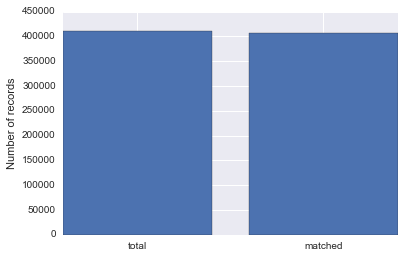

In [3]:
# Number of records/identities:
tot = engine.execute('SELECT count(*) from dedupe.entries').fetchone()[0]
uniq = engine.execute('SELECT count(*) from dedupe.entries_unique').fetchone()[0]
tot_matched = engine.execute('SELECT count(dedupe_id) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [tot,tot_matched],tick_label=['total','matched'],align='center');
plt.ylabel("Number of records");

print("{}/{} ({}%) records matched".format(tot_matched, tot, 100*tot_matched/tot))

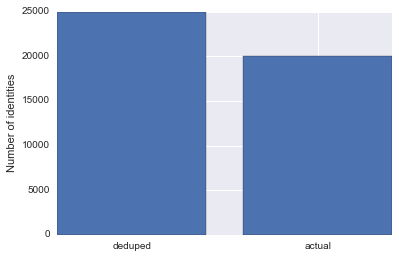

In [4]:
dedup = engine.execute('SELECT count(distinct dedupe_id) from dedupe.entries').fetchone()[0]
actual = engine.execute('SELECT count(distinct uuid) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [dedup,actual],tick_label=['deduped','actual'],align='center');
plt.ylabel("Number of identities");

# Overall error rates per entry

In [5]:
# Compute the most common UUID for each dedupe'd cluster
engine.execute("""DROP TABLE IF EXISTS results""")
engine.execute("""CREATE TABLE results as (
    SELECT uuid, dedupe_id, mode, uuid = mode as correct
    from dedupe.entries
    left join (SELECT dedupe_id, mode() within group (order by uuid) from dedupe.entries group by 1) e using(dedupe_id))""", engine)

In [6]:
# The overall accuracy: percent of entries correctly linked to their cluster
engine.scalar("SELECT sum(correct::INT)*1.0/count(*) from results")

Decimal('0.98250817608225029161')

In [7]:
# We ignored some entries due to insufficient information:
engine.scalar("SELECT sum((correct is null)::INT)*1.0 / count(*) from results")

Decimal('0.00754902605388056467')

In [8]:
# Errors due to merging to a cluster that has plurality-other identity
engine.scalar("SELECT 1 - sum(correct::INT)*1.0/count(correct) from results")

Decimal('0.01001842723206289305')

In [9]:
# Errors due to falsely splitting clusters
df = pd.read_sql("""SELECT mode, max(sum), sum(sum) as total, sum(sum) - max(sum) as misses FROM (
            SELECT dedupe_id, mode, count(*), sum(correct::INT) from results group by 1, 2) e group by mode""", engine)
df.misses.sum() / df.total.sum()

0.016060832883068213

# Falsely merged identity clusters

In [10]:
df = pd.read_sql('SELECT dedupe_id, count(distinct uuid) from dedupe.entries where dedupe_id is not null group by dedupe_id', engine)
print("{} falsely merged identities; {}% of all identities".format(sum(df['count'] > 1), 100*sum(df['count'] > 1)/actual))
dups = df[df['count'] > 1].dedupe_id

376 falsely merged identities; 1.88% of all identities


In [ ]:
# Some are twins:
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {} order by uuid, entry_id'.format(dups.iloc[6]), engine)

In [ ]:
# And some are just very tough cases:
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[8]), engine)

In [ ]:
# But some could definitely be resolved and improved -- these just have a very similar DOB and the same last name.
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {} limit 10'.format(dups.iloc[7]), engine)

# Split identities

In [14]:
# Number of persons that got split into two identities
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) from dedupe.entries group by uuid', engine)
sum(df['count'] > 1)

4499

In [15]:
splits = df[df['count'] > 1].uuid
# Some of these are very obvious, and should have been captured:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(splits.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,003ef0fa-c6d1-40a1-b5c1-629c47abcf71,Christopher,Shah,None,M,1977-03-16,white,None,268269,Christopher Shah,172688
1,003ef0fa-c6d1-40a1-b5c1-629c47abcf71,Christopher,Shah,032-65-1685,M,1977-03-06,white,hispanic,268266,Christopher Shah,131550
2,003ef0fa-c6d1-40a1-b5c1-629c47abcf71,Christopher,Shah,032-65-1685,M,None,white,nonhispanic,268268,Christopher Shah,131550
3,003ef0fa-c6d1-40a1-b5c1-629c47abcf71,Christopher,Shah,032-65-1685,M,None,white,nonhispanic,268267,Christopher Shah,131550
4,003ef0fa-c6d1-40a1-b5c1-629c47abcf71,Christopher,Shah,032-65-1685,M,1977-03-06,white,nonhispanic,268270,Christopher Shah,131550


# Ignored persons

In [16]:
# Number of persons that were ignored entirely
sum(df['count'] == 0)

8

In [17]:
ignores = df[df['count'] == 0].uuid
# These records simply had insufficient data and were excluded by rule:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(ignores.iloc[0]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,18963260-ea94-4397-9665-5810e0dd04f8,Jeremy,Harris,None,M,None,other,hispanic,99296,Jeremy Harris,None


# Incomplete persons

In [18]:
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) as identities, count(dedupe_id)*1.0/count(*) as completeness from dedupe.entries group by uuid', engine)
sum(df[(df.identities == 1)].completeness < 1)

1825

In [19]:
incompletes = df[(df.identities == 1) & (df.completeness < 1)].uuid
# Like above, these persons just had some records with insufficient data that were excluded by rule
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(incompletes.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Taylor,289-30-4880,None,1982-09-24,white,nonhispanic,374007,Jennifer Taylor,105567.0
1,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Taylor,289-30-4880,F,1982-09-24,white,nonhispanic,374032,Jennifer Taylor,105567.0
2,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Taylor,289-30-4880,F,1982-09-24,white,nonhispanic,373986,Jennifer Taylor,105567.0
3,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Taylor,289-30-4880,F,1982-09-24,white,nonhispanic,374016,Jennifer Taylor,105567.0
4,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Taylor,289-30-4880,F,1982-09-24,None,None,374023,Jennifer Taylor,105567.0
5,003edf31-eca2-4d67-9538-1beedab95c8c,Jenny,Taylor,289-30-4880,F,1982-09-24,white,nonhispanic,374003,Jenny Taylor,105567.0
6,003edf31-eca2-4d67-9538-1beedab95c8c,Jennie,Wilson,289-30-4880,F,1982-09-24,white,nonhispanic,373977,Jennie Wilson,105567.0
7,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Taylor,289-30-4880,F,1982-09-24,white,nonhispanic,373984,Jennifer Taylor,105567.0
8,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Wilson,289-30-4880,F,1982-09-24,white,None,373973,Jennifer Wilson,105567.0
9,003edf31-eca2-4d67-9538-1beedab95c8c,Jennifer,Wilson,None,F,None,white,nonhispanic,373975,Jennifer Wilson,NaN


# Percent of identities that were complete

In [20]:
df = pd.read_sql("""SELECT uuid, max(count)/sum(count) as pct_complete from
                        (SELECT uuid, dedupe_id, count(*) from dedupe.entries group by 1, 2) e group by 1""", engine)


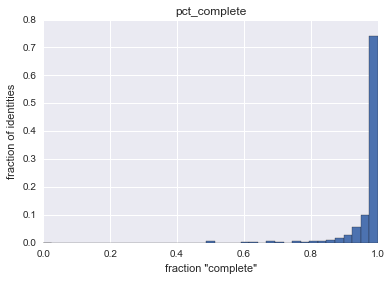

In [21]:
df.hist('pct_complete',bins=np.linspace(0,1,40), weights=np.ones(len(df))/len(df))
plt.xlabel('fraction "complete"')
plt.ylabel('fraction of identities')

In [22]:
sum(df.pct_complete == 1.0)/actual

0.68379999999999996

In [23]:
sum(df.pct_complete >= .9)/actual

0.92559999999999998

In [24]:
split_identities = df[df.pct_complete < .5]
pd.read_sql("""SELECT * FROM DEDUPE.ENTRIES where uuid='{}' order by dedupe_id""".format(split_identities.uuid.iloc[3]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Mollie,Duncan,786-57-9675,F,2009-06-13,white,None,284886,Mollie Duncan,8083
1,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Duncan,786-57-9675,F,2009-06-13,asian,nonhispanic,284888,Molly Duncan,8083
2,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Duncan,786-57-9675,F,2009-06-13,white,None,284891,Molly Duncan,8083
3,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Duncan,None,F,2009-06-13,asian,None,284887,Molly Duncan,8083
4,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Duncan,786-57-9675,F,2009-06-13,white,nonhispanic,284890,Molly Duncan,8083
5,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Duncan,786-57-9675,F,2009-08-18,white,None,284889,Molly Duncan,8083
6,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Patel,786-57-9675,F,2009-06-13,white,None,284894,Molly Patel,49938
7,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Patel,786-57-9675,F,2009-06-13,other,nonhispanic,284892,Molly Patel,49938
8,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Molly,Patel,786-57-9675,F,2009-06-13,white,nonhispanic,284897,Molly Patel,49938
9,0f420cdc-37d7-4653-bbe7-d6f11db3c517,Mollie,Patel,786-57-9675,F,2009-06-13,white,None,284895,Mollie Patel,49938


In [26]:
df[df.pct_complete < .4]

,uuid,pct_complete
2886,c9910a92-7574-4528-8d1c-295d710a7e48,0.333333
13095,2a542393-a0fa-4dbd-a8fe-dc4c91386369,0.375000
14295,721ec736-0b46-45f0-8bcb-ac14e57af607,0.333333
17254,0ef6d34b-34e4-4615-877e-7054870d11f4,0.333333
18839,571a44a5-c1de-4527-b905-a7ca99ded9b7,0.333333
